<a href="https://colab.research.google.com/github/e9anna/book_algorithm/blob/main/Stacking_Test_Sklearn%2C_XGBoost%2C_CatBoost%2C_LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



*   목적: 예측
*   상세목적: 고객이 얼마나 대출을 상환할 수 있을 지 예측
*   기대효과: 상환 능력이 있는 고객이 거절 당하지 않을 수 있다. 

> 통신사와 거래정보를 포함한 다양한 대체 데이터를 통하여 고객의 상환능력을 예측










# 1. 라이브러리 import 및 데이터 준비 

In [1]:
! pip3 install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# 필요한 라이브러리 
import pandas as pd
import numpy as np
from scipy.stats import skew
import xgboost as xgb
from sklearn.model_selection import cross_val_score
# from sklearn.cross_validation import KFold -> 이부분은 아래로 바뀜
from sklearn.model_selection import KFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from math import sqrt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
#catboost 모델은 ! pip3 install catboost로 먼저 불러와야 한다. 
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import gc

In [3]:
NFOLDS = 3
SEED = 0
NROWS = None

In [4]:
test = pd.read_csv('/content/drive/MyDrive/데이터분석_강의/kaggle/application_test.csv')
data = pd.read_csv('/content/drive/MyDrive/데이터분석_강의/kaggle/application_train.csv')
prev = pd.read_csv('/content/drive/MyDrive/데이터분석_강의/kaggle/previous_application.csv')

In [5]:
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [7]:
test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB


In [9]:
prev.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
prev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

In [11]:
# y_train이라는 변수로 따로 train data set (변수명:data)의 Target 열을 빼준다. 
y_train = data['TARGET']
# 기존의 data에는 Target 열 삭제
del data['TARGET']

In [12]:
categorical_feats = [
    f for f in data.columns if data[f].dtype == 'object'
]
# data에서 객체 타입인 데이터의 경우 categorical_feats 리스트 형태로 저장

In [13]:
for f_ in categorical_feats:
    data[f_], indexer = pd.factorize(data[f_]) #열거 된 유형 또는 범주 형 변수로 개체를 인코딩
    test[f_] = indexer.get_indexer(test[f_]) #현재 데이터를 새 인덱스에 맞춤
    
gc.enable()

In [14]:
prev_cat_features = [
    f_ for f_ in prev.columns if prev[f_].dtype == 'object'
]
for f_ in prev_cat_features:
    prev[f_], _ = pd.factorize(prev[f_])

SK_ID_CURR : 예측 대상이 되는 고객

In [15]:
avg_prev = prev.groupby('SK_ID_CURR').mean() #개별 ID로 그룹지어 놓은 것의 평균
cnt_prev = prev[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count() #ID_CURR로 그룹짓고 개수를 카운트
avg_prev['nb_app'] = cnt_prev['SK_ID_PREV']
del avg_prev['SK_ID_PREV']

In [16]:
x_train = data.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR') #SK_ID_CURR를 기준으로 데이터 병합
x_test = test.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')

In [17]:
x_train = x_train.fillna(0) #null값은 모두 0으로 채워 넣음 
x_test= x_test.fillna(0)

In [18]:
ntrain = x_train.shape[0] #x_train.shape의 결과값 중 첫 번째 값을 ntrain으로 지정
ntest = x_test.shape[0]

In [19]:
excluded_feats = ['SK_ID_CURR'] 
features = [f_ for f_ in x_train.columns if f_ not in excluded_feats] #예측 대상이 되는 고객을 열에서 제거하기 위해서 해당 변수를 사용

In [20]:
x_train = x_train[features] #위의 제거된 열들로 이루어진 것을 다시 x_train으로 저장
x_test = x_test[features]

In [21]:
kf = KFold(n_splits = NFOLDS, shuffle=True, random_state=SEED)

- Kfold 교차 검증
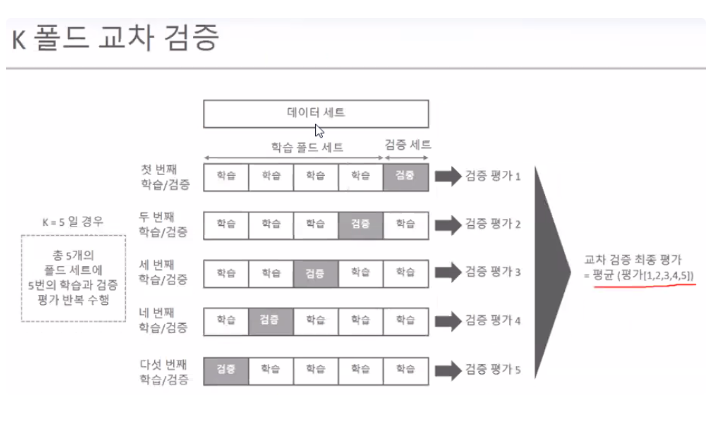

In [22]:
class SklearnWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]

In [23]:
class CatboostWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_seed'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]

In [24]:
class LightGBMWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['feature_fraction_seed'] = seed
        params['bagging_seed'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]

In [25]:
class XgbWrapper(object):
    def __init__(self, seed=0, params=None):
        self.param = params
        self.param['seed'] = seed
        self.nrounds = params.pop('nrounds', 250)

    def train(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, label=y_train)
        self.gbdt = xgb.train(self.param, dtrain, self.nrounds)

    def predict(self, x):
        return self.gbdt.predict(xgb.DMatrix(x))

In [26]:
def get_oof(clf):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train.loc[train_index]
        y_tr = y_train.loc[train_index]
        x_te = x_train.loc[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [27]:
et_params = {
    'n_jobs': 16,
    'n_estimators': 200,
    'max_features': 0.5,
    'max_depth': 12,
    'min_samples_leaf': 2,
}

In [28]:
rf_params = {
    'n_jobs': 16,
    'n_estimators': 200,
    'max_features': 0.2,
    'max_depth': 12,
    'min_samples_leaf': 2,
}

In [29]:
xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.7,
    'silent': 1,
    'subsample': 0.7,
    'learning_rate': 0.075,
    'objective': 'binary:logistic',
    'max_depth': 4,
    'num_parallel_tree': 1,
    'min_child_weight': 1,
    'nrounds': 200
}

In [30]:
catboost_params = {
    'iterations': 200,
    'learning_rate': 0.5,
    'depth': 3,
    'l2_leaf_reg': 40,
    'bootstrap_type': 'Bernoulli',
    'subsample': 0.7,
    'scale_pos_weight': 5,
    'eval_metric': 'AUC',
    'od_type': 'Iter',
    'allow_writing_files': False
}

In [31]:
lightgbm_params = {
    'n_estimators':200,
    'learning_rate':0.1,
    'num_leaves':123,
    'colsample_bytree':0.8,
    'subsample':0.9,
    'max_depth':15,
    'reg_alpha':0.1,
    'reg_lambda':0.1,
    'min_split_gain':0.01,
    'min_child_weight':2    
}

In [32]:
xg = XgbWrapper(seed=SEED, params=xgb_params)
et = SklearnWrapper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
rf = SklearnWrapper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
cb = CatboostWrapper(clf= CatBoostClassifier, seed = SEED, params=catboost_params)
lg = LightGBMWrapper(clf = LGBMClassifier, seed = SEED, params = lightgbm_params)

In [33]:
xg_oof_train, xg_oof_test = get_oof(xg)


In [34]:
et_oof_train, et_oof_test = get_oof(et)
rf_oof_train, rf_oof_test = get_oof(rf)
cb_oof_train, cb_oof_test = get_oof(cb)

0:	total: 132ms	remaining: 26.3s
1:	total: 213ms	remaining: 21.1s
2:	total: 274ms	remaining: 18s
3:	total: 353ms	remaining: 17.3s
4:	total: 440ms	remaining: 17.1s
5:	total: 511ms	remaining: 16.5s
6:	total: 586ms	remaining: 16.1s
7:	total: 652ms	remaining: 15.6s
8:	total: 725ms	remaining: 15.4s
9:	total: 809ms	remaining: 15.4s
10:	total: 874ms	remaining: 15s
11:	total: 951ms	remaining: 14.9s
12:	total: 1.03s	remaining: 14.9s
13:	total: 1.11s	remaining: 14.7s
14:	total: 1.19s	remaining: 14.6s
15:	total: 1.26s	remaining: 14.5s
16:	total: 1.32s	remaining: 14.2s
17:	total: 1.38s	remaining: 14s
18:	total: 1.46s	remaining: 13.9s
19:	total: 1.53s	remaining: 13.8s
20:	total: 1.6s	remaining: 13.6s
21:	total: 1.66s	remaining: 13.4s
22:	total: 1.74s	remaining: 13.4s
23:	total: 1.8s	remaining: 13.2s
24:	total: 1.87s	remaining: 13.1s
25:	total: 1.95s	remaining: 13s
26:	total: 2.02s	remaining: 12.9s
27:	total: 2.08s	remaining: 12.8s
28:	total: 2.16s	remaining: 12.7s
29:	total: 2.23s	remaining: 12.6s


In [35]:
print("XG-CV: {}".format(sqrt(mean_squared_error(y_train, xg_oof_train))))
print("ET-CV: {}".format(sqrt(mean_squared_error(y_train, et_oof_train))))
print("RF-CV: {}".format(sqrt(mean_squared_error(y_train, rf_oof_train))))
print("RF-CV: {}".format(sqrt(mean_squared_error(y_train, cb_oof_train))))

XG-CV: 0.2596818070894085
ET-CV: 0.26296502347137407
RF-CV: 0.2629856213006646
RF-CV: 0.3309547098229581


In [36]:
x_train = np.concatenate((xg_oof_train, et_oof_train, rf_oof_train, cb_oof_train), axis=1)
x_test = np.concatenate((xg_oof_test, et_oof_test, rf_oof_test, cb_oof_test), axis=1)

In [37]:
print("{},{}".format(x_train.shape, x_test.shape))

(307511, 4),(48744, 4)


In [38]:
logistic_regression = LogisticRegression()
logistic_regression.fit(x_train,y_train)

LogisticRegression()

In [39]:
test['TARGET'] = logistic_regression.predict_proba(x_test)[:,1]

In [40]:
test[['SK_ID_CURR', 'TARGET']].to_csv('first_submission.csv', index=False, float_format='%.8f')

In [ ]:
first_submission.csv